# Mutation-Based Fuzzing

Most [randomly generated inputs](Basic_Fuzzing.ipynb) are syntactically _invalid_ and thus are quickly rejected by the processing program.  To exercise functionality beyond input processing, we must increase chances to obtain valid inputs.  One such way is by _mutating_ existing valid inputs - that is, introducing small changes that may still keep the input valid, yet exercise new behavior.

**Prerequisites**

* You should know how basic fuzzing works; for instance, from the ["Fuzzing"](Basic_Fuzzing.ipynb) chapter.

## Fuzzing a URL Parser

Many programs expect their inputs to come in a very specific format before they would actually process them.  As an example, think of a program that accepts a URL (a Web address).  The URL has to be in a valid format (i.e., the URL format) such that the program can deal with it.  When fuzzing with random inputs, what are our chances to actually produce a valid URL?

To get deeper into the problem, let us explore what URLs are made of.  A URL consists of a number of elements:

    scheme://netloc/path?query#fragment
    
where
* `scheme` is the protocol to be used, including `http`, `https`, `ftp`, `file`...
* `netloc` is the name of the host to connect to, such as `www.google.com`
* `path` is the path on that very host, such as `search`
* `query` is a list of key/value pairs, such as `q=fuzzing`
* `fragment` is a marker for a location in the retrieved document, such as `#result`

In Python, we can use the `urlparse()` function to parse and decompose a URL into its parts.

In [78]:
import gstbook

In [79]:
try:
    from urlparse import urlparse      # Python 2
except ImportError:
    from urllib.parse import urlparse  # Python 3

urlparse("http://www.google.com/search?q=fuzzing")

ParseResult(scheme='http', netloc='www.google.com', path='/search', params='', query='q=fuzzing', fragment='')

We see how the result encodes the individual parts of the URL in different attributes.

Let us now assume we have a program that takes a URL as input.  To simplify things, we won't let it do very much; we simply have it check the passed URL for validity.  If the URL is valid, it returns True; otherwise, it raises an exception.

In [80]:
def http_program(url):
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " + repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True

Let us now go and fuzz `http_program()`.  To fuzz, we use the full range of printable ASCII characters, such that `:`, `/`, and lowercase letters are included.

In [81]:
%%capture
from Basic_Fuzzing import fuzzer

In [82]:
fuzzer(char_start=32, char_range=96)

"zaT2C?RV0&Y\x7f^jOQ]R2e;|/,{6pLmt*:cC7=il'>b'Y~/_0g<4X}h{'st?Vqxtv@n"

Let's try to fuzz with 1000 random inputs and see whether we have some success.

In [83]:
for i in range(1000):
    try:
        url = fuzzer()
        result = http_program(url)
        print("Success!")
    except ValueError:
        pass

What are the chances of actually getting a valid URL?  We need our string to start with `"http://"` or `"https://"`.  Let's take the `"http://"` case first.  That's seven very specific characters we need to start with.  The chances of producing these seven characters randomly (with a character range of 96 different characters) is $1 : 96^7$, or

In [84]:
96 ** 7

75144747810816

The odds of producing a `"https://"` prefix are even worse, at $1 : 96^8$:

In [85]:
96 ** 8

7213895789838336

which gives us a total chance of

In [86]:
likelihood = 1 / (96 ** 7) + 1 / (96 ** 8)
likelihood

1.344627131107667e-14

And this is the number of runs (on average) we'd need to produce a valid URL:

In [87]:
1 / likelihood

74370059689055.02

Let's measure how long one run of `http_program()` takes:

In [88]:
%%capture
from Timer import Timer

In [89]:
TRIALS = 1000
with Timer() as t:
    for i in range(TRIALS):
        try:
            url = fuzzer()
            result = http_program(url)
            print("Success!")
        except ValueError:
            pass

duration_per_run_in_seconds = t.elapsed_time() / TRIALS
duration_per_run_in_seconds

0.00013728549506049603

That's pretty fast, isn't it?  Unfortunately, we have a lot of runs to cover.

In [90]:
seconds_until_success = duration_per_run_in_seconds * (1 / likelihood)
seconds_until_success

10209930462.090557

which translates into

In [91]:
hours_until_success = seconds_until_success / 3600
days_until_success = hours_until_success / 24
years_until_success = days_until_success / 365.25
years_until_success

323.5331730578548

Even if we parallelize things a lot, we're still in for months to years of waiting.  And that's for getting _one_ successful run that will get deeper into `http_program()`.

What basic fuzzing will do well is to test `urlparse()`, and if there is an error in this parsing function, it has good chances of uncovering it.  But as long as we cannot produce a valid input, we are out of luck in reaching any deeper functionality.

## Mutating Inputs

The alternative to generating random strings from scratch is to start with a guiven _valid_ input, and then to subsequently _mutate_ it.  A _mutation_ in this context is a simple string manipulation - say, inserting a (random) character, deleting a character, or flipping a bit in a character representation.  Here are some mutations to get you started:

In [92]:
import random

In [93]:
def delete_random_character(s):
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    # print("Deleting", repr(s[pos]), "at", pos)
    return s[:pos] + s[pos + 1:]

In [94]:
seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(x)

A quickbrown fox
A quck brown fox
A quick brwn fox
A uick brown fox
A quick brown fo
A quick rown fox
A quick brownfox
A quic brown fox
A quickbrown fox
A quick brown fo


In [95]:
def insert_random_character(s):
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 128))
    # print("Inserting", repr(random_character), "at", pos)
    return s[:pos] + random_character + s[pos:]

In [96]:
for i in range(10):
    print(insert_random_character(seed_input))

A% quick brown fox
A quick brown fo{x
A qu4ick brown fox
AA quick brown fox
A quick bOrown fox
A qu)ick brown fox
A quick brow_n fox
A qMuick brown fox
A quick browhn fox
A &quick brown fox


In [97]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]


In [98]:
for i in range(10):
    print(flip_random_character(seed_input))

a quick brown fox
A quick brown fmx
A`quick brown fox
A quick broun fox
A quick broun fox
A quick brown gox
A qukck brown fox
A quiak brown fox
A quick brown fox
A quibk brown fox


Let us now create a random mutator that randomly chooses which mutation to apply:

In [99]:
mutators = [delete_random_character, insert_random_character, flip_random_character]

In [100]:
def mutate(s):
    """Return s with a random mutation applied"""
    mutator = random.choice(mutators)
    # print(mutator)
    return mutator(s)

In [101]:
for i in range(10):
    print(mutate("A quick brown fox"))

A quic?k brown fox
A quYick brown fox
A quick brow fox
/A quick brown fox
A quick brow. fox
A quick crown fox
A uick brown fox
 quick brown fox
A quiak brown fox
A uick brown fox


The idea is now that _if_ we have some valid input(s) to begin with, we may create more input candidates by applying one of the above mutations.  To see how this works, let's get back to URLs.

## Mutating URLs

Let us now get back to our URL parsing problem.  Let us create a function `is_valid_url()` that checks whether `http_program()` accepts the input.

In [102]:
def is_valid_url(url):
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False

In [103]:
assert is_valid_url("http://www.google.com/search?q=fuzzing")
assert not is_valid_url("xyzzy")

Let us now apply the `mutate()` function on a given URL and see how many valid inputs we obtain.

In [104]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
TRIALS = 20

for i in range(TRIALS):
    inp = mutate(seed_input)
    if is_valid_url(inp):
        valid_inputs.add(inp)

We can now observe that by _mutating_ the original input, we get a high proportion of valid inputs:

In [105]:
len(valid_inputs) / TRIALS

0.7

What are the odds of also producing a `https:` prefix by mutating a `http:` sample seed input?  We have to insert ($1 : 3$) the right character `'s'` ($1 : 96$) into the correct position ($1 : l$), where $l$ is the length of our seed input.  This means that on average, we need this many runs:

In [106]:
trials = 3 * 96 * len(seed_input)
trials

10944

We can actually afford this.  Let's try:

In [107]:
%%capture
from Timer import Timer

In [108]:
trials = 0
with Timer() as t:
    while True:
        trials += 1
        inp = mutate(seed_input)
        if inp.startswith("https://"):
            print("Success after", trials, "trials in", t.elapsed_time(), "seconds")
            break

Success after 846 trials in 0.005797673016786575 seconds


Of course, if we wanted to get, say, an `"ftp://"` prefix, we would need more mutations and more runs – most important, though, we would need to apply _multiple_ mutations.

## Multiple Mutations

So far, we have only applied one single mutation on a sample string.  However, we can also apply _multiple_ mutations, further changing it.  What happens, for instance, if we apply, say, 20 mutations on our sample string?

In [109]:
seed_input = "http://www.google.com/search?q=fuzzing"
MUTATIONS = 50

In [110]:
inp = seed_input
for i in range(MUTATIONS):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'http://w.9google.com/searh?q=fwzzing'
10 mutations: 'h\x7fttp://.9oogle.com/sarh?q=fwzing'
15 mutations: 'h\x7fttp//.oogle.ckm/sarh\x1fq=fwzig'
20 mutations: 'h\x7ftt//.oogle.cm/sgar\x1fq=fwzi@g'
25 mutations: 'h\x7fSttn//.ongjle.cm/sgar\x1fu=fwzi@g'
30 mutations: 'h\x7fSttn//.Ogjle.cm/sgar\x1f9uC=fzi@g'
35 mutations: 'h\x7fSttnm//.OgjlTe.cm/sgar\x1f9qC=fzw\x7fi@g'
40 mutations: 'h\x7fSttnm//.Og nlT.cm/{gar\x1f9qC=fzw\x7fi@gP'
45 mutations: 'h\x7fSttnm//.Og nT.cm/{gar?9qC=z\x7fi@gP('


As you see, the original seed input is hardly recognizable anymore.  Mutating the input again and again has the advantage of getting a higher variety in the input, but on the other hand further increases the risk of having an invalid input.  The key to success lies in the idea of _guiding_ these mutations – that is, _keeping those that are especially valuable._

## Guiding by Coverage

To cover as much functionality as possible, one can rely on either _specified_ or _implemented_ functionality, as discussed in the ["Coverage"](Coverage.ipynb) chapter.  For now, we will not assume that there is a specification of program behavior (although it _definitely_ would be good to have one!).  We _will_ assume, though, that the program to be tested exists – and that we can leverage its structure to guide test generation.

Since testing always executes the program at hand, one can always gather information about its execution – the least is the information needed to decide whether a test passes or fails.  Since coverage is frequently measured as well to determine test quality, let us also assume we can retrieve coverage of a test run.  The question is then: _How can we leverage coverage to guide test generation?_

One particularly successful idea is implemented in the popular fuzzer named [_American fuzzy lop_](http://lcamtuf.coredump.cx/afl/), or AFL for short.  Just like our examples above, AFL evolves test cases that have been successful – but for AFL, "success" means _finding a new path through the program execution_.  This way, AFL can keep on mutating inputs that so far have found new paths; and if an input finds another path, it will be retained as well.

We can implement such a strategy by maximizing _diversity in coverage_ in our population.  First, let us create a function `create_candidate()` which randomly picks some input from a given population, and then applies between `min_mutations` and `max_mutations` mutation steps, returning the final result:

In [116]:
def create_candidate(population, min_mutations=2, max_mutations=10):
    candidate = random.choice(population)
    trials = random.randint(min_mutations, max_mutations)
    for i in range(trials):
        candidate = mutate(candidate)
    return candidate

Now for the main function.  We maintain a list of inputs (`population`) and a set of coverages already achieved (`coverages_seen`).  The `fuzz()` helper function takes an input and runs the given `function()` on it.  If its coverage is new (i.e. not in `coverages_seen`), the input is added to `population` and the coverage to `coverages_seen`.

The main `coverage_fuzzer()` function first runs `fuzz()` on the provided seed population (adding to the population), and then keeps on creating and testing new candidates coming from `create_candidate()`.

In [117]:
%%capture
from Coverage import Coverage, population_coverage

In [118]:
def coverage_fuzzer(seed, function, trials=100):
    population = []
    coverages_seen = set()

    def fuzz(inp):
        """Run function(inp) while tracking coverage.  
           If we reach new coverage, 
           add inp to population and its coverage to population_coverage
        """
        nonlocal population  # Access "outer" variables
        nonlocal coverages_seen

        with Coverage() as cov:
            try:
                function(inp)
                valid = True
            except:
                valid = False

        print(repr(inp))

        new_coverage = frozenset(cov.coverage())
        if valid and new_coverage not in coverages_seen:
            # We have new coverage
            population.append(inp)
            coverages_seen.add(new_coverage)

    for inp in seed:
        fuzz(inp)

    for i in range(trials):
        candidate = create_candidate(population)
        fuzz(candidate)

    return population

Let us now put this to use:

In [119]:
seed_input = "http://www.google.com/search?q=fuzzing"
population = coverage_fuzzer(
    seed=[seed_input], function=http_program, trials=1000)
population

'http://www.google.com/search?q=fuzzing'
"'http:\x0f/wwwgoZole.col/searc?q=fUuzzhlg"
'http://wwg\x0ego;ogle.comsarch?q=fuzzng'
'http://www.googlencom/searc?q=fuxzing'
'ht\\Op//wwg\x0ego;ogle\x0ecFgmsrch/q=fuzzn'
'htup://nwww.gooolencomsarch?qP=fuzgzing'
'http://wg\x0eGo?og#lg.coqaRch?q=u/zzng'
'http://wwg\x0ego;ogle.comsar;ch?q=fuzng'
'hptp//wbg\x0eGo?og#lggoqRch?q=u/zzng'
'hptp:/-www.gzoog|e.com/search?q=fuzzing'
'httt://wg\x0eGo?g#lg.coqaRch?q=u/zzng'
'hvt:/wg\x0eGo?og#lg.mcoqach?q+w=u/zzng'
'1http:/wg\x0eGo?og#Lg.coqa2Rch?q=u/zzng'
'http://wg\x0eGo/og#lg.cgqaRch?q=u/zzng'
'htp://wvw.googme.com/search?q=f|5ujzng'
'he6tpc://wg\nGo?og#|Dg.coqRch?q=u/zzn'
"h$tHt:/wwg\x0ego;oglE.co#sjarch?q=fuzn'"
'http://wwgU\x0egooglge.#omr#tH7q=fuzzng'
'http://wwg\x0ego;ogle.comsarSh?q=fuzzng'
"http://wf\x0eGo?og#l'.coqaRch?q=\\u/zzng"
'http://wg\x0eFo?ow#lg.coqaRch?q=u/zng'
"ht(tp://wwwgoogle.co/se!arcj?`=fuzzi'ng"
'httpK://wg\x0eGo?og#lw.coqaRch`q=u/zzng'
'http://g\x0eGSo?g#lg.boqaRch7q=uzznNg'
'htt

['http://www.google.com/search?q=fuzzing',
 'http://wwg\x0ego;ogle.comsarch?q=fuzzng',
 'http://wg\x0eGo?og#lg.coqaRch?q=u/zzng',
 'http://wg\x0eGo/og#lg.cgqaRch?q=u/zzng',
 'http://www.g"oogle.com/jsearchq<fuzzing',
 'http://wwg\x0ego4+oele.cgmsa4rch?q=fuzzng',
 'http://wg\x0eGo/oBg#lg.ggqaRch?qu/zzng',
 'http://www\x0egoogle.c/m/sapch;s=fzing5`',
 'http://\x7fwg\x0eo;ogle%.comsarch>s=guFzzng',
 'http://\x7fsg\x0eo;ogle%&omhsarkh>q=guFzzng',
 'http://www."oogle.comM/jsearchq<fuzzin',
 'htTp://ww\x0egooglm.#/m/sapch;bs=fzi3ng5`',
 'htTp://ww>googlm/./m/Archs=fzi3ng%5`',
 'httP://\x7fwg\x0eo;ogle%.comsarch:>s=?guFzzng',
 'hTtp://sg\x0eol;ogl;e%&omhsarkh>q=jguGzzng',
 'http://www\x0egboogle.c/m/sJach;s?fzing5`',
 'htTp://ww\x0eg,ognlm.#/m/sapch;bs=fi3ng5`']

Success!  In our population, _each and every input_ now is valid and has a different coverage, coming from various combinations of schemes, paths, queries, and fragments.

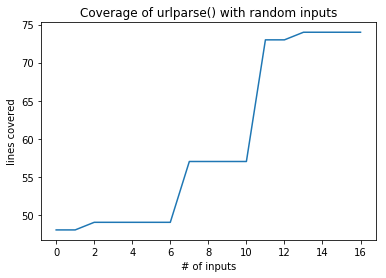

In [120]:
cumulative_coverage = population_coverage(population, http_program)

import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

The nice thing about this strategy is that, applied to larger programs, it will happily explore one path after the other – covering functionality after functionality.  All that is needed is a means to capture the coverage.

## Lessons Learned

* Randomly generated inputs are frequently invalid – and thus exercise mostly input processing functionality.
* Mutations from existing valid inputs have much higher chances to be valid, and thus to exercise functionality beyond input processing.


## Next Steps

Our aim is still to sufficiently cover functionality.  From here, we can continue with:

1. Try to cover as much _implemented_ functionality as possible.  To this end, we need to access the program implementation, measure which parts would actually be reached with our inputs, and use this _coverage_ to guide our search.  We will explore this in the next chapter, which discusses [guided mutations](Guided_Mutations.ipynb).

2. Try to cover as much _specified_ functionality as possible.  Here, we would need a _specification of the input format,_ distinguishing between individual input elements such as (in our case) numbers, operators, comments, and strings – and attempting to cover as many of these as possible.  We will explore this as it comes to [grammar-based testing](Grammar_Testing.ipynb), and especially in [grammar-based mutations](Grammar_Mutations.ipynb).

Finally, the concept of a "population" that is systematically "evolved" through "mutations" will be explored in depth when discussing [search-based testing](Search_Based_Testing.ipynb).  Enjoy!


## Exercises


### Exercise 1

Apply the above non-guided mutation-based fuzzing technique on `bc`, using files, as in the chapter ["Introduction to Fuzzing"](Basic_Fuzzing.ipynb).

### Exercise 2

Apply the above guided mutation-based fuzzing technique on `cgi_decode()` from the ["Coverage"](Coverage.ipynb) chapter.  How many trials do you need until you cover all variations of `+`, `%` (valid and invalid), and regular characters?

In [ ]:
%%capture
from Coverage import cgi_decode

In [ ]:
if __name__ == "__main__":   # Long-running input
    seed_input = "Hello World"
    population = coverage_fuzzer(
        seed=[seed_input], function=cgi_decode, trials=100000)
    print(population)

In [ ]:
cumulative_coverage = population_coverage(population, cgi_decode)

import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

### Exercise 3

In this [blog post](https://lcamtuf.blogspot.com/2014/08/binary-fuzzing-strategies-what-works.html), the author of _American Fuzzy Lop_ (AFL), a very popular mutation-based fuzzer discusses the efficiency of various mutation operators.  Implement four of them and evaluate their efficiency as in the examples above.

### Exercise 4

When adding a new element to the list of candidates, AFL does actually not compare the _coverage_, but adds an element if it exercises a new _branch_.  Using branch coverage from the exercises of the ["Coverage"](Coverage.ipynb) chapter, implement this "branch" strategy and compare it against the "coverage" strategy, above.

### Exercise 5

Design and implement a system that will gather a population of URLs from the Web.  Can you achieve a higher coverage with these samples?  What if you use them as intiial population for further mutation?